In [1]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

import pathlib
import os 
import numpy as np
from string import ascii_uppercase
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt
from glob import glob
from pandas import DataFrame
from keras.models import Model
from keras.layers import Flatten, Dense, GlobalAveragePooling2D, Conv2D,MaxPooling2D, Dropout

from keras.applications.vgg19 import VGG19
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.applications.vgg16 import preprocess_input
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.models import Sequential
import seaborn as sn
from sklearn.metrics import confusion_matrix, precision_score, recall_score, classification_report, accuracy_score, f1_score
import keras
from sklearn.utils import class_weight
import imageio
import random
from tensorflow.keras.preprocessing import image
from keras.utils.np_utils import to_categorical
from keras import backend as K

#from yellowbrick.classifier import ClassificationReport

Using TensorFlow backend.


In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

Endereço dos conjuntos

In [3]:
path = '../../data_especular_crop/'
training_dir = str(path)+'train_imagesAmostras'
validation_dir = str(path)+'val_images'
test_dir = str(path)+'test_images'

img = imageio.imread(str(path)+'train_images/confluente/0.png')
sizeX, sizeY,_ = img.shape
print("Tamanho original: ")
print(sizeX, sizeY)

sizeX = sizeX//2#256
sizeY = sizeY//2#256


print("Tamanho definido: ")
print(sizeX, sizeY)


batch_size = 64
epocas = 20


Tamanho original: 
460 245
Tamanho definido: 
230 122


In [4]:
def visualizarOrganizacao(diretorio, fase):
    data_dir = pathlib.Path(diretorio)
    # Verificando quantas imagens tem nos diretórios
    image_count = len(list(data_dir.glob('*/*.png')))
    print("Quantidade total de Imagens no "+str(fase)+": "+ str(image_count))

    CLASS_NAMES = np.array([item.name for item in data_dir.glob('*')])
    # Print das categorias 
    print('Classes/rótulos: ', CLASS_NAMES)

    # Visualizando o tamanho de cada classe
    fnames = []
    for classes in CLASS_NAMES:
        images_folder = os.path.join(data_dir, classes)
        file_names    = os.listdir(images_folder)
        full_path     = [os.path.join(images_folder, file_name) for file_name in file_names]
        fnames.append(full_path)

        tamanho_classes = [len(f) for f in fnames]

    explode = (0.4, 0.4, 0, 0.4)  # only "explode" the 2nd slice (i.e. 'Hogs')

    fig1, ax1 = plt.subplots()
    ax1.pie(tamanho_classes, explode=explode, labels=CLASS_NAMES, autopct='%1.1f%%',
            shadow=True, startangle=90)
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

    plt.show()
    return tamanho_classes, CLASS_NAMES

In [5]:
# Função para exibir o desempenho do modelo em treino e teste
def plot_model(model_name, history, epochs):

    print(model_name)
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2 ,1)
    plt.plot(np.arange(0, len(history['precision_m'])), history['precision_m'], 'r')
    plt.plot(np.arange(1, len(history['val_precision_m'])+1), history['val_precision_m'], 'g')
    plt.xticks(np.arange(0, epochs+1, epochs/10))
    plt.title('Training Precision vs. Validation Precision')
    plt.xlabel('Nro de Epochs')
    plt.ylabel('Precision')
    plt.legend(['train', 'validation'], loc='best')

    plt.subplot(1, 2, 2)
    plt.plot(np.arange(1, len(history['recall_m'])+1), history['recall_m'], 'r')
    plt.plot(np.arange(1, len(history['val_recall_m'])+1), history['val_recall_m'], 'g')
    plt.xticks(np.arange(0, epochs+1, epochs/10))
    plt.title('Training Recall vs. Validation Recall')
    plt.xlabel('Nro de Epochs')
    plt.ylabel('Recall')
    plt.legend(['train', 'validation'], loc='best')
    plt.show()

In [6]:
def prepareData(training_dir, validation_dir, test_dir):
    folders = glob(training_dir + '/*')
    num_classes = len(folders) 

    train_datagen = ImageDataGenerator(
        rescale=1./255,
       # rotation_range=180,
      #  rescale=1./255,
       # width_shift_range=0.2,
      #  height_shift_range=0.2,
       # shear_range=0.2, #cisalhamento
       # zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip = True
        #fill_mode='nearest'
        )
    
    # exemplo de geração de imagens
    img = load_img(str(path)+'train_images/confluente/0.png')  # this is a PIL image
    x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
  #  print(x)
    x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)

    
    # the .flow() command below generates batches of randomly transformed images
    # and saves the results to the `preview/` directory
    i = 0
    for batch in train_datagen.flow(x, batch_size=1,
                                    save_to_dir=str(path)+'/preview', 
                                    save_prefix='con', 
                                    save_format='jpeg'):
     #   print(batch)
        i += 1
        if i > 20:
            break  # otherwise the generator would loop indefinitely

    train_datagen = ImageDataGenerator(rescale=1./255) 
    val_datagen = ImageDataGenerator(rescale=1./255)  
    test_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_directory(
        training_dir,
        target_size=(sizeX, sizeY),
         batch_size=batch_size,
        class_mode='categorical')  
   
   # print(train_generator.flow)
    validation_generator = val_datagen.flow_from_directory(
        validation_dir,
        target_size=(sizeX, sizeY),
        batch_size=batch_size,
        class_mode='categorical')
    
    test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(sizeX, sizeY),
        batch_size=batch_size,
        class_mode='categorical')    
    

    
    
    return train_generator, validation_generator, test_generator, num_classes  

In [7]:
def plotMatrix(data, model, fase, tipoM):    
    Y_pred = model.predict_generator(data)
    
    y_pred = np.argmax(Y_pred, axis=1)
    
   # print(data.classes, y_pred)

    ax = sn.heatmap(confusion_matrix(data.classes, y_pred), 
                    annot=True, 
                    cmap='Blues',  fmt='g')
    ax.set_title('Matriz de confusão - '+ str(fase) + " - " + str(tipoM));          
    plt.show()
    
    print("Classification Report:")
    print(classification_report(data.classes, y_pred))    

In [8]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


In [9]:
def treinarVGG19(train_generator, validation_generator, test_generator, num_classes, epocas):
    
    IMAGE_SIZE = [sizeX, sizeY]  

    vgg = VGG19(input_shape = IMAGE_SIZE + [3], 
                weights = 'imagenet', 
                include_top = False)  
    
    for layer in vgg.layers:
        layer.trainable = False

    x = Flatten()(vgg.output)
    x = Dense(num_classes, activation = 'softmax')(x)  

    model = Model(inputs = vgg.input, outputs = x)    
    #model.summary()
    model.compile(loss='categorical_crossentropy',
                        optimizer='adam',
                        metrics=['acc',f1_m,precision_m, recall_m])

    # criar ponto de salvamento com base no melhor modelo obtido
    checkpointer = ModelCheckpoint(str(path)+'/pesos/BestCheckPointVGG19.hdf5', verbose=1,save_best_only=True)
    stopper = EarlyStopping(monitor='val_acc',min_delta=0.1,patience=0,verbose=1,mode='auto')

    # VGG 16
    history = model.fit(train_generator,
                    steps_per_epoch=train_generator.n//batch_size,
                    epochs=epocas,
                    validation_data=validation_generator,
                    validation_steps=validation_generator.n//batch_size,
                    shuffle = True,
                  #  class_weight=class_weights,
                    callbacks=[checkpointer])  
    
    plot_model('Modelo VGG19', history.history, epocas)
  #  plotMatrix(train_generator, model, "treinamento", "VGG19")
    
  #  plotMatrix(test_generator, model, "teste", "VGG19")
        
  #  plotMatrix(validation_generator, model, "validação", "VGG19")
    
    return model

In [10]:
def predizer(model, img_path, classe):
    img = image.load_img(img_path, target_size=(sizeX, sizeY))   
    img_array = image.img_to_array(img)
    img_batch = np.expand_dims(img_array, axis=0)
    img_preprocessed = preprocess_input(img_batch)
    prediction = model.predict(img_preprocessed)
    
    classePred = np.argmax(prediction)
    
    plt.title(str(classePred) + " - " + str(classe))
    plt.imshow(img)
    plt.show()

In [11]:
def predizerVariasAmostras(model):    
    imgURL = np.array([[[str(path)+'test_images/confluente/61.png'], [0]],
           [[str(path)+'test_images/esparsa/199.png'], [1]],
           [[str(path)+'test_images/integra/229.png'], [2]],
           [[str(path)+'test_images/rara/1332.png'], [3]]])
    plt.figure(figsize=(15,10))
    for i in range(imgURL.shape[0]):
        endereco = imgURL[i][0][0]
        classe = imgURL[i][1][0]
        
        plt.subplot(1,4,i+1)
        img = image.load_img(endereco, target_size=(sizeX, sizeY))   
        img_array = image.img_to_array(img)
        img_batch = np.expand_dims(img_array, axis=0)
        img_preprocessed = preprocess_input(img_batch)
        prediction = model.predict(img_preprocessed)
    
        classePred = np.argmax(prediction)
    
        plt.title(str(classe) + " - " + str(classePred))
        plt.imshow(img)
    plt.show()
        

In [12]:
def predizerConjunto(model, classes, path, NomeModelo, NomeConjunto):
    predicoes = []
    classes = []
    predicoesN = []
    classesN = []
    directory_contents = os.listdir(path)
    for i in range(len(directory_contents)):
        diretorio = str(path) + "/" + str(directory_contents[i])+"/"
        lista = os.listdir(diretorio)
        for j in range(len(lista)):
            img_path = str(path) + "/" + str(directory_contents[i])+"/"+str(lista[j])
            img = image.load_img(img_path, target_size=(sizeX, sizeY))
            img_array = image.img_to_array(img)
            img_batch = np.expand_dims(img_array, axis=0)
            img_preprocessed = preprocess_input(img_batch)
            prediction = model.predict(img_preprocessed)
            classePred = np.argmax(prediction)
            classes.append(i)
            classesN.append(directory_contents[i])
            predicoes.append(classePred)
            predicoesN.append(directory_contents[classePred])

    ax = sn.heatmap(confusion_matrix(classes, predicoes), 
                    annot=True, 
                    cmap='Blues',  fmt='g')
    ax.set_title('Matriz de confusão - ' + str(NomeModelo) + " - " + str(NomeConjunto));          
    plt.show()

Found 3213 images belonging to 4 classes.
Found 437 images belonging to 4 classes.
Found 435 images belonging to 4 classes.
Epoch 1/20
50/50 [==============================] - 32s 644ms/step - loss: 0.8068 - acc: 0.6599 - f1_m: 0.5867 - precision_m: 0.7084 - recall_m: 0.5138 - val_loss: 0.6418 - val_acc: 0.7500 - val_f1_m: 0.7258 - val_precision_m: 0.7724 - val_recall_m: 0.6849

Epoch 00001: val_loss improved from inf to 0.64180, saving model to ../../data_especular_crop//pesos/BestCheckPointVGG19.hdf5
Epoch 2/20
50/50 [==============================] - 421s 8s/step - loss: 0.5228 - acc: 0.7882 - f1_m: 0.7760 - precision_m: 0.8101 - recall_m: 0.7450 - val_loss: 0.5920 - val_acc: 0.7426 - val_f1_m: 0.7356 - val_precision_m: 0.7903 - val_recall_m: 0.6887

Epoch 00002: val_loss improved from 0.64180 to 0.59196, saving model to ../../data_especular_crop//pesos/BestCheckPointVGG19.hdf5
Epoch 3/20
50/50 [==============================] - 459s 9s/step - loss: 0.4676 - acc: 0.8104 - f1_m: 0.80

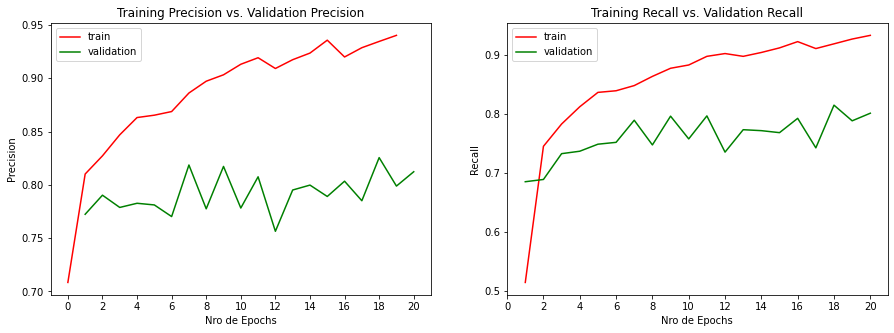

In [13]:
train_generator, validation_generator, test_generator, num_classes = prepareData(training_dir, validation_dir, test_dir)

modelo = treinarVGG19(train_generator, validation_generator, test_generator, num_classes, epocas)

modeloTreinado = "VGG19"

In [14]:
modelo.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 230, 122, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 230, 122, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 230, 122, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 115, 61, 64)       0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 115, 61, 128)      73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 115, 61, 128)      147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 57, 30, 128)       0   

In [15]:
from keras.models import load_model
modelo.save(str(path)+'pesos/ColabLastPointVGG19.hdf5')

In [16]:
print("Avaliação do modelo")
print("Treinamento")
print(modelo.evaluate(train_generator, verbose=1))
print("teste")
print(modelo.evaluate(test_generator, verbose=1))

Avaliação do modelo
Treinamento
51/51 [==============================] - 402s 8s/step
[0.17650701105594635, 0.9337068200111389, 0.9323780536651611, 0.9381214380264282, 0.926800549030304]
teste
7/7 [==============================] - 217s 31s/step
[0.5219791531562805, 0.8183907866477966, 0.8080193400382996, 0.8227797746658325, 0.7939425706863403]
